# **🎶 SIGNAL CLUSTERING (HEARTBEAT)🫀**




## Library

In [ ]:
! pip install python_speech_features -qq

In [ ]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from google.colab import drive
from sklearn.manifold import TSNE
from python_speech_features import mfcc
from sklearn.mixture import GaussianMixture
import IPython.display as ipd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


## Load Data

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path ke folder di Google Drive
folder_path = '/content/drive/MyDrive/heartbeat/set_b'

# List semua file dalam folder
files = os.listdir(folder_path)

# File wav berdasarkan index datake
datake = 0
file = files[datake]

# Buka file wav
wav_file = wave.open(os.path.join(folder_path, file), 'r')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Basic information about the wav file
num_channels = wav_file.getnchannels() # Jumlah kanal audio (1 untuk mono, 2 untuk stereo)
sample_width = wav_file.getsampwidth() # Ukuran sampel dalam byte
frame_rate = wav_file.getframerate()  # Sample rate (samples per second)
num_frames = wav_file.getnframes() # Jumlah total frame dalam file audio.
duration = num_frames / float(frame_rate)  # Duration in seconds

print("Channels:", num_channels)
print("Sample Width:", sample_width, "bytes")
print("Frame Rate:", frame_rate, "Hz")
print("Number of Frames:", num_frames)
print("Duration:", duration, "seconds")

Channels: 1
Sample Width: 2 bytes
Frame Rate: 4000 Hz
Number of Frames: 87248
Duration: 21.812 seconds


Audio Array: [ 217 -108  -21 ...  597  505  421]
Array Shape: (87248,)


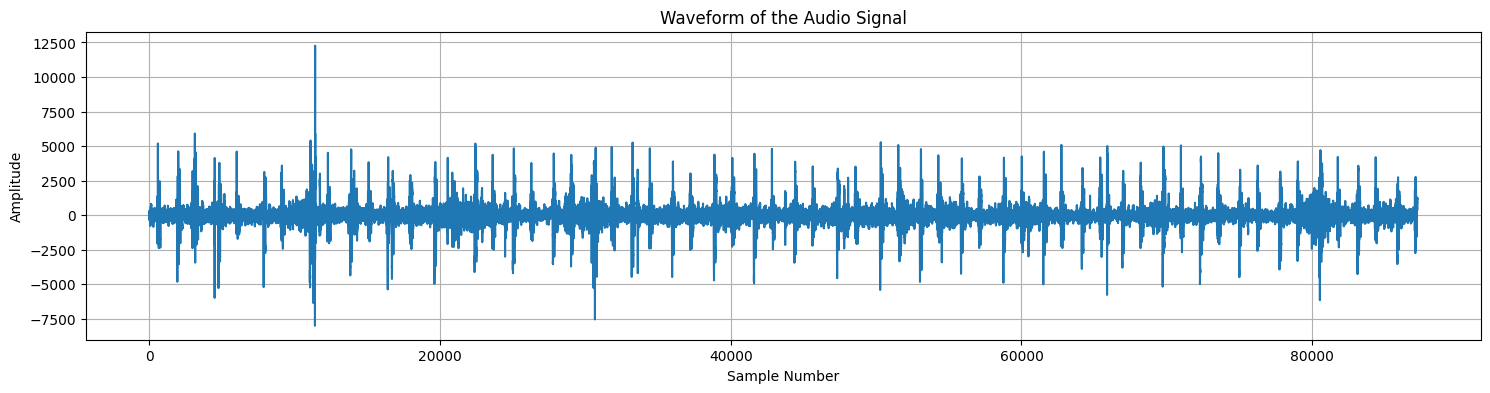

In [ ]:
frames = wav_file.readframes(num_frames)
wav_file.close()

audio_data = np.frombuffer(frames, dtype=np.int16) #konversi data biner ke numpy array

if num_channels > 1:
    audio_data = np.reshape(audio_data, (-1, num_channels))

print("Audio Array:", audio_data)
print("Array Shape:", audio_data.shape)

plt.figure(figsize=(18, 4))
if num_channels > 1:
    plt.plot(audio_data[:, 0])
else:
    plt.plot(audio_data)

plt.title('Waveform of the Audio Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

## Extraction Feature MFCC

In [ ]:
# Ekstraksi MFCC menggunakan python_speech_features
mfcc_features = mfcc(audio_data, samplerate=frame_rate, numcep=13)
print(f"MFCC Shape: {mfcc_features.shape}")

MFCC Shape: (2180, 13)


## Reduction (t-SNE)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


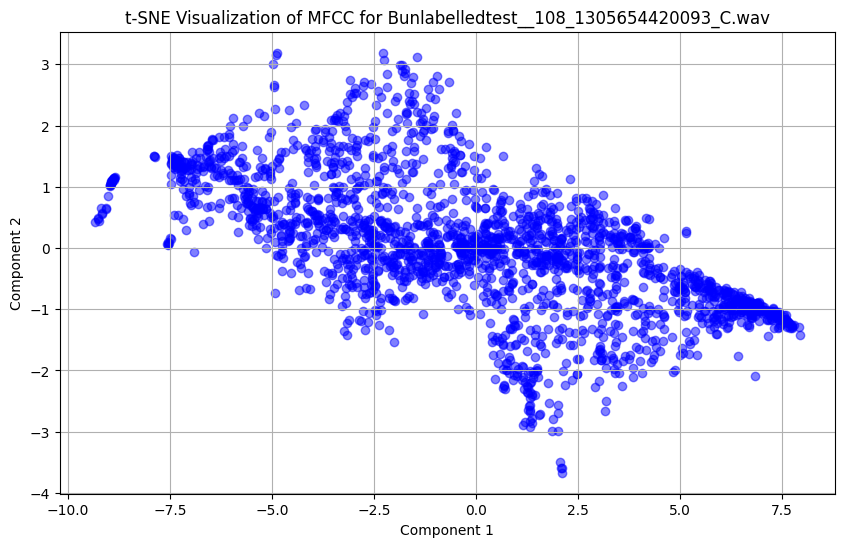

In [ ]:
# t-SNE untuk visualisasi 2D dari MFCC
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
mfcc_tsne = tsne.fit_transform(mfcc_features)

# Visualisasi hasil t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(mfcc_tsne[:, 0], mfcc_tsne[:, 1], c='blue', marker='o', alpha=0.5)
plt.title(f't-SNE Visualization of MFCC for {file}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid()
plt.show()


## Clustering Gaussian Mixture Model

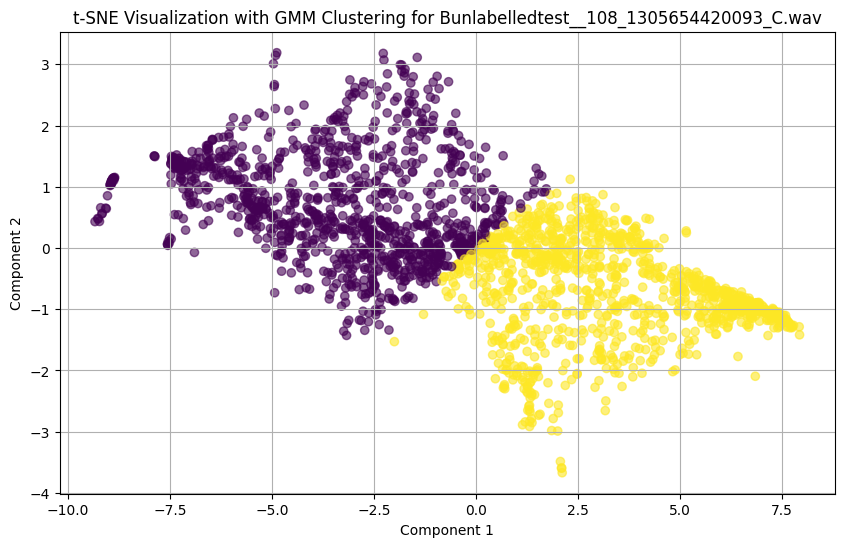

In [ ]:
# Clustering MFCC features using Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=2,random_state=42 ,covariance_type='full')
gmm.fit(mfcc_tsne)

# Predict clusters
clusters = gmm.predict(mfcc_tsne)

# Visualisasi clustering hasil GMM
plt.figure(figsize=(10, 6))
plt.scatter(mfcc_tsne[:, 0], mfcc_tsne[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.6)
plt.title(f't-SNE Visualization with GMM Clustering for {file}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid()
plt.show()


Plot tersebut dibagi menjadi dua kluster yang direpresentasikan dengan dua warna berbeda (ungu dan kuning)

In [ ]:
# Inisialisasi list untuk menyimpan MFCC tiap cluster
cluster_mfcc = {i: [] for i in range(gmm.n_components)}

# Pisahkan MFCC ke dalam cluster-cluster
for i, mfcc_row in enumerate(mfcc_features):
    cluster_mfcc[clusters[i]].append(mfcc_row)

# Hitung statistik dasar per cluster
for cluster_id, mfcc_data in cluster_mfcc.items():
    mfcc_data = np.array(mfcc_data)
    print(f"Cluster {cluster_id}:")
    print(f"  Mean MFCC:\n{np.mean(mfcc_data, axis=0)}")
    print(f"  Variance MFCC:\n{np.var(mfcc_data, axis=0)}")
    print(f"  Range MFCC:\n{np.ptp(mfcc_data, axis=0)}\n")



Cluster 0:
  Mean MFCC:
[ 14.35119407  -3.86745814  -8.41091984  -5.76726941 -14.18867217
  -1.20296454 -11.48981195   5.90835133  -6.68943307   7.93194046
  -6.21123015   1.07175812  -4.09366067]
  Variance MFCC:
[  1.00170656  61.76567997  24.38217521  60.57045352  64.70357549
  64.45479785  78.08955331  67.28841384  75.26859408 107.01947652
  91.71766789  70.72423718  65.04599073]
  Range MFCC:
[ 4.94850481 45.92052803 36.75711037 48.9511379  50.97050009 57.15054186
 60.45106254 54.57723141 61.19855173 63.43199598 60.78474011 66.33095895
 59.71559678]

Cluster 1:
  Mean MFCC:
[14.09106533 -4.75036446 -4.93831095  1.12155554 -5.4531121   8.17641303
 -3.63171933 11.68954246 -5.81168901  8.94863629 -2.05947124  6.13326348
 -3.34112802]
  Variance MFCC:
[ 0.47743162 47.01552215 47.13171277 62.45025817 49.48607447 57.41930915
 54.51620354 74.13517846 84.64753207 71.62264875 86.55290787 77.25910392
 61.1244349 ]
  Range MFCC:
[ 5.02948148 42.99159639 37.18858214 51.64453801 38.15156222 51

**Cluster 0** merepresentasikan sinyal yang lebih bervariasi dengan **variasi frekuensi yang lebih besar** dan perubahan intensitas yang lebih signifikan, sedangkan **Cluster 1** memiliki **sinyal yang lebih konsisten** dengan distribusi energi yang lebih kuat di frekuensi-frekuensi tertentu.


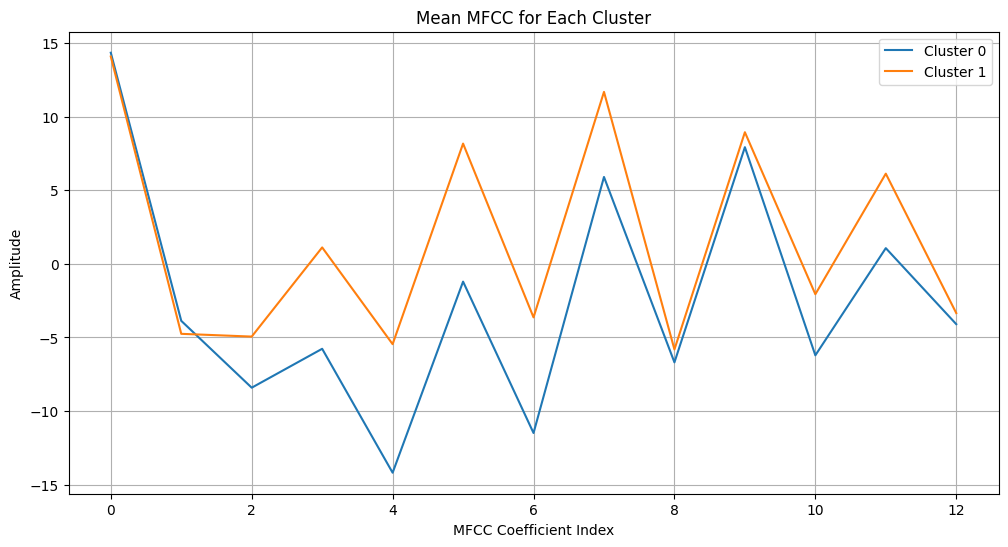

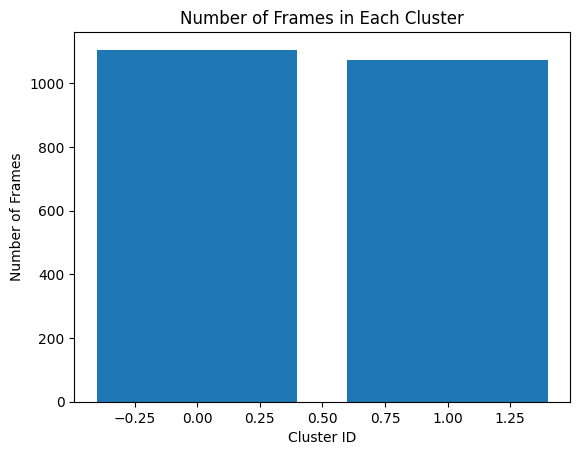

In [ ]:
# Visualisasi rata-rata MFCC untuk tiap cluster
plt.figure(figsize=(12, 6))
for cluster_id, mfcc_data in cluster_mfcc.items():
    mfcc_data = np.array(mfcc_data)
    mean_mfcc = np.mean(mfcc_data, axis=0)
    plt.plot(mean_mfcc, label=f"Cluster {cluster_id}")

plt.title('Mean MFCC for Each Cluster')
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

# Visualisasi jumlah frame di setiap cluster
unique, counts = np.unique(clusters, return_counts=True)
plt.bar(unique, counts)
plt.title('Number of Frames in Each Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Frames')
plt.show()


**Cluster 1** memiliki nilai **rata-rata koefisien MFCC yang cenderung lebih tinggi di beberapa frekuensi**, yang menunjukkan adanya suara dengan intensitas yang lebih tinggi atau lebih jelas pada frekuensi tertentu dibandingkan dengan Cluster 0.

In [ ]:
# Play audio per cluster
for cluster_id in range(gmm.n_components):
    cluster_frames = np.where(clusters == cluster_id)[0]

    # Ambil data audio yang sesuai dengan cluster
    audio_segment = []
    for frame in cluster_frames:
        start_idx = int(frame * (len(audio_data) / len(mfcc_tsne)))
        end_idx = int((frame + 1) * (len(audio_data) / len(mfcc_tsne)))
        audio_segment.extend(audio_data[start_idx:end_idx])

    # Ubah ke numpy array
    audio_segment = np.array(audio_segment, dtype=np.int16)

    # Putar audio dari cluster
    print(f"Cluster {cluster_id} Audio:")
    ipd.display(ipd.Audio(audio_segment, rate=frame_rate))

Cluster 0 Audio:


Cluster 1 Audio:


In [ ]:
# Simpan nama file dan cluster yang ditugaskan ke dalam list
cluster_results = []
for idx, file in enumerate(files):
    cluster_results.append((file, clusters[idx]))
import pandas as pd
df_results = pd.DataFrame(cluster_results, columns=['File Name', 'Cluster'])
df_results.head()

,File Name,Cluster
0,Bunlabelledtest__108_1305654420093_C.wav,1
1,Bunlabelledtest__103_1305031931979_C.wav,1
2,Bunlabelledtest__109_1305653972028_D.wav,0
3,Bunlabelledtest__107_1305654946865_B.wav,0
4,Bunlabelledtest__109_1305653646620_D.wav,1


In [ ]:
# prompt: simpan df_results

# Simpan DataFrame ke file CSV di Google Drive
df_results.to_csv('/content/drive/MyDrive/cluster_results.csv', index=False)


## Metric Score

In [ ]:
# Silhouette Score
silhouette_avg = silhouette_score(mfcc_tsne, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(mfcc_tsne, clusters)
print(f'Davies-Bouldin Index: {davies_bouldin}')

# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(mfcc_tsne, clusters)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')


Silhouette Score: 0.5270959138870239
Davies-Bouldin Index: 0.6457577753218312
Calinski-Harabasz Index: 4145.454556873665


**Silhouette Score**

Nilai 0,527 menandakan bahwa sebagian besar data tercluster dengan baik, namun tidak sempurna. Kemungkinan sebagian besar sampel dalam kluster memiliki jarak antar kluster yang cukup baik dibandingkan dengan jarak sampel di dalam klusternya sendiri, namun ada beberapa sampel yang mungkin ditempatkan pada batas kluster. Seperti yang terlihat di plot cluster ada sedikit overlap di batasnya

**Davies-Bouldin Index**

Nilai 0,645 menunjukkan bahwa kluster yang dihasilkan cukup terpisah dan terkompresi.

**Calinski-Harabasz Index**

Nilai 4145.45 tergolong cukup tinggi, menunjukkan bahwa kluster yang dihasilkan memiliki pemisahan yang sangat jelas dan data dalam masing-masing kluster memiliki dispersi internal yang rendah, yang merupakan tanda klasterisasi yang baik.


---

Berdasarkan ketiga metrik ini, model klusterisasi yang dilakukan dengan GMM sudah cukup baik dalam memisahkan sinyal audio atau fitur MFCC menjadi dua kelompok (Cluster 0 dan Cluster 1). Namun, nilai Silhouette Score di sekitar 0,5 menandakan bahwa ada beberapa data yang mungkin tidak terkelompok dengan ideal, sehingga masih ada ruang untuk perbaikan atau optimalisasi model lebih lanjut.

link notebook: https://colab.research.google.com/drive/1zBhYR5fRQ9USHS-DWQwlZYN9XuwVhSBh?usp=sharing